# From the normal model to regression

##### Keywords: bayesian, normal-normal model, conjugate prior, MCMC engineering, pymc3, regression

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The example we use here is described in McElreath's book, and our discussion mostly follows the one there, in sections 4.3 and 4.4. We have used code from https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_04.ipynb .

## Howell's data

These are census data for the Dobe area !Kung San (https://en.wikipedia.org/wiki/%C7%83Kung_people). Nancy Howell conducted detailed quantitative studies of this Kalahari foraging population in the 1960s.

In [2]:
df = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
df.tail()

,height,weight,age,male
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1
543,158.750,52.531624,68.0,1


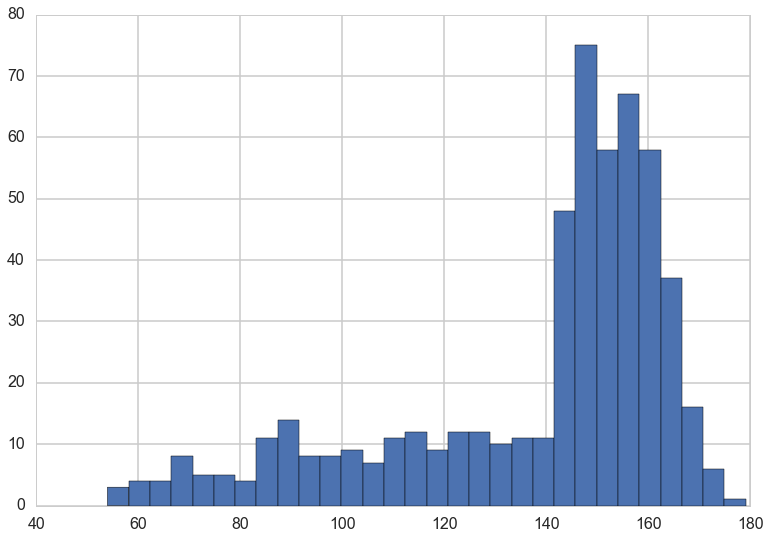

In [4]:
plt.hist(df.height, bins=30);

We get rid of the kids and only look at the heights of the adults.

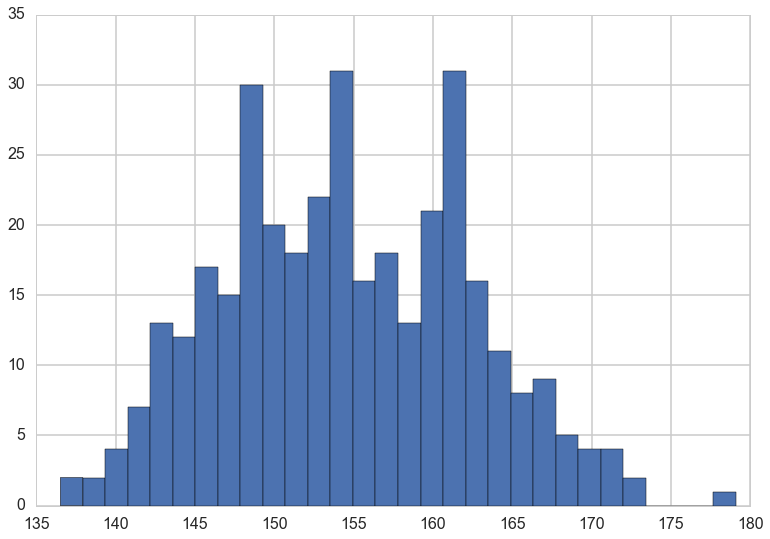

In [5]:
df2 = df[df.age >= 18]
plt.hist(df2.height, bins=30);

## Model for heights

We will now get relatively formal in specifying our models.

We will use a Normal model, $h \sim N(\mu, \sigma)$, and assume that the priors are independent. That is $p(\mu, \sigma) = p(\mu \vert \sigma) p(\sigma) = p(\mu)p(\sigma)$.

Our model is:

$$
h \sim N(\mu, \sigma)\\
\mu \sim Normal(148, 20)\\
\sigma \sim Unif(0, 50)
$$

In [6]:
import pymc3 as pm

### A pymc3 model

We now write the model as a pymc3 model. You will notice that the code pretty much follows our formal specification above.

When we were talking about gibbs in a Hierarchical model, we suggested that software uses the  Directed Acyclic Graph (DAG) structure of our models to make writing conditionals easy.

This is exactly what `pymc` does. A "Deterministic Random Variable" is one whose values are  determined by its parents, and a "Stochastic Random Variable" has these parental dependencies but is specified by them only upto some sampling. 

Deterministic nodes use `pm.Deterministic` or plain python code, while Stochastics come from distributions, and then belong to the `pm.FreeRV`

So for example, the likelihood node in the graph below,  depends on the mu and sigma nodes as its parents, but is not fully specified by them.

Specifically, a likelihood stochastic is an instance of the `ObservedRV` class.

A Stochastic always has a `logp`,  the log probability of the variables current value, given that of its parents. Clearly this is needed to do any metropolis stuff! `pymc` provides this for many distributions, but we can easily add in our own.

In [7]:
with pm.Model() as hm1:
    mu = pm.Normal('mu', mu=148, sd=20)#parameter
    sigma = pm.Uniform('sigma', lower=0, upper=20)#testval=df2.height.mean()
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

`testval` can be used to pass a starting point.

In [8]:
with hm1:
    stepper=pm.Metropolis()
    tracehm1=pm.sample(10000, step=stepper)# a start argument could be used here
    #as well

100%|██████████| 10000/10000 [00:02<00:00, 4180.50it/s] | 1/10000 [00:00<16:55,  9.84it/s]


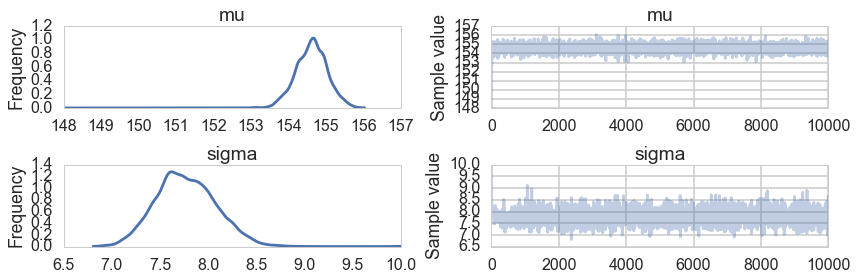

In [9]:
pm.traceplot(tracehm1);

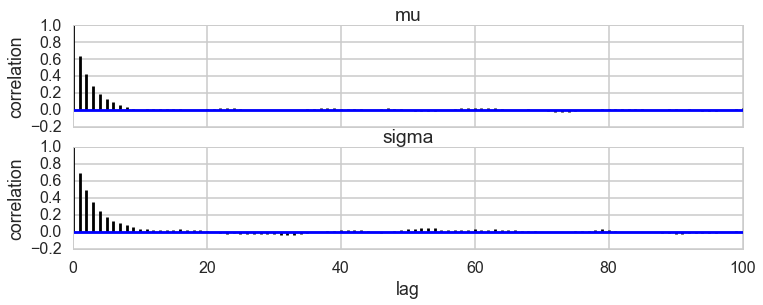

In [10]:
pm.autocorrplot(tracehm1);

In [11]:
pm.summary(tracehm1)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  154.593          0.433            0.010            [153.744, 155.402]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  153.751        154.321        154.610        154.878        155.411


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.774            0.311            0.008            [7.221, 8.408]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  7.214          7.562          7.753          7.979          8.401



An additional dataframe for the summary is available as well

In [12]:
pm.df_summary(tracehm1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,154.593240,0.433314,0.010416,153.744155,155.401749
sigma,7.774233,0.310829,0.007543,7.221390,8.408288


A very nice hack to find the acceptance values is below, which I found at the totally worth reading tutorial [here](http://rlhick.people.wm.edu/stories/bayesian_7.html).

In [13]:
tracehm1['mu'][1:]

array([ 148.80116545,  149.54102138,  150.12631238, ...,  154.00413466,
        154.00413466,  154.10020739])

In [14]:
tracehm1['mu'][:-1]

array([ 148.        ,  148.80116545,  149.54102138, ...,  154.10122607,
        154.00413466,  154.00413466])

In [15]:
def acceptance(trace, paramname):
    accept = np.sum(trace[paramname][1:] != trace[paramname][:-1])
    return accept/trace[paramname].shape[0]

In [16]:
acceptance(tracehm1, 'mu'), acceptance(tracehm1, 'sigma')

(0.3896, 0.30009999999999998)

### How strong is the prior?

Above we had used a very diffuse value on the prior. But suppose we tamp it down instead, as in the model below.

In [17]:
with pm.Model() as hm1dumb:
    mu = pm.Normal('mu', mu=178, sd=0.1)#parameter
    sigma = pm.Uniform('sigma', lower=0, upper=50)#testval=df2.height.mean()
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)

In [18]:
with hm1dumb:
    stepper=pm.Metropolis()
    tracehm1dumb=pm.sample(10000, step=stepper)

100%|██████████| 10000/10000 [00:02<00:00, 3792.84it/s] | 263/10000 [00:00<00:03, 2628.60it/s]


In [19]:
pm.df_summary(tracehm1dumb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,177.859012,0.101756,0.002275,177.650239,178.054321
sigma,24.593284,0.932395,0.023867,22.620644,26.275036


Ok, so our `mu` did not move much from our prior. But see how much larger our `sigma` became to compensate. One way to think about this is that . 0.1 standard deviation on the posterior corrsponds to a "prior N" of 100 points (1/0.1^2) in contrast to a 20 standard deviation. 

## Regression: adding a predictor

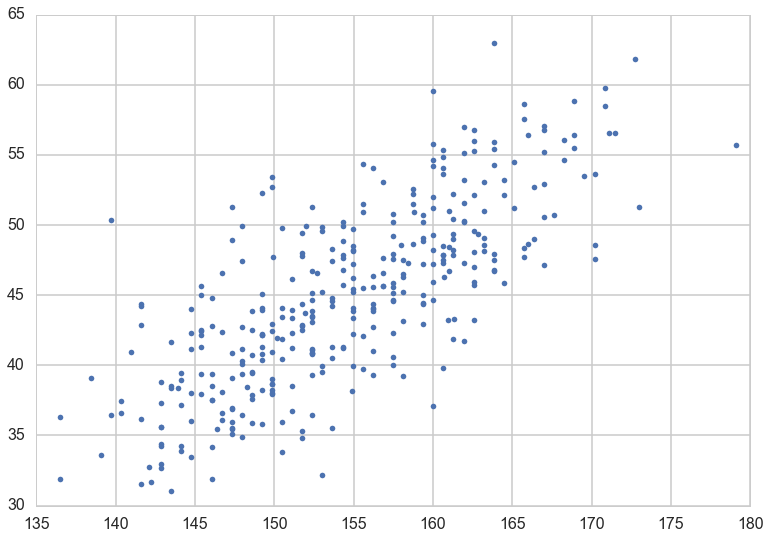

In [20]:
plt.plot(df2.height, df2.weight, '.');

So lets write our model out now:

$$
h \sim N(\mu, \sigma)\\
\mu = intercept + slope \times weight\\
intercept \sim N(150, 100)\\
slope \sim N(0, 10)\\
\sigma \sim Unif(0, 50)
$$

Why should you not use a uniform prior on a slope?

In [21]:
with pm.Model() as hm2:
    intercept = pm.Normal('intercept', mu=150, sd=100)
    slope = pm.Normal('slope', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # below is a deterministic
    mu = intercept + slope * df2.weight
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)
    stepper=pm.Metropolis()
    tracehm2 = pm.sample(10000, step=stepper)

100%|██████████| 10000/10000 [00:03<00:00, 3181.30it/s] | 220/10000 [00:00<00:04, 2196.55it/s]


The $\mu$ now becomes a deterministic node, as it is fully known once we know the slope and intercept.

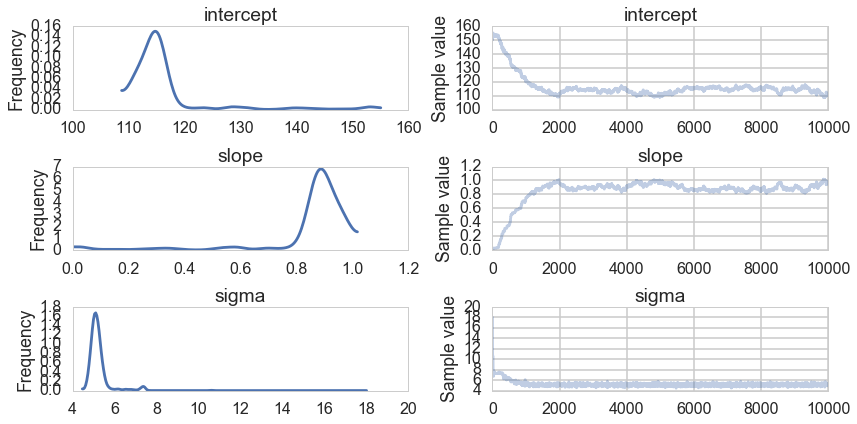

In [22]:
pm.traceplot(tracehm2);

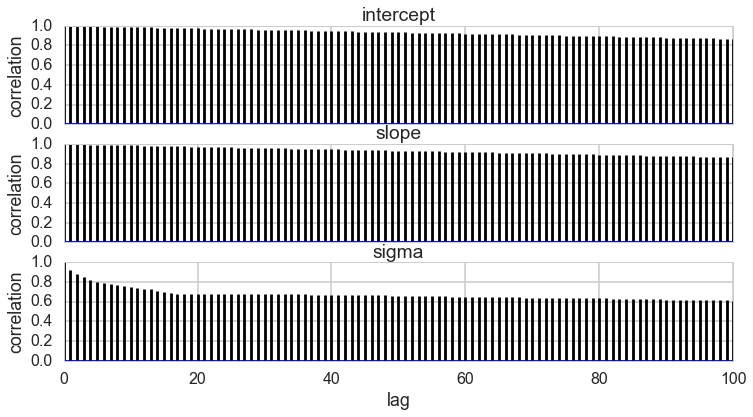

In [23]:
pm.autocorrplot(tracehm2);

In [24]:
acceptance(tracehm2, 'intercept'), acceptance(tracehm2, 'slope'), acceptance(tracehm2, 'sigma')

(0.3236, 0.23949999999999999, 0.29249999999999998)

Oops, what happened here? Our correlations are horrendous and the traces look awful. Our acceptance rates dont seem to be at fault.

### Centering to remove correlation : identifying information in our parameters.

The slope and intercept are very highly correlated:

In [25]:
hm2df=pm.trace_to_dataframe(tracehm2)
hm2df.head()

,sigma,slope,intercept
0,18.006883,0.0,150.090145
1,13.242113,0.0,150.796693
2,13.242113,0.0,150.706993
3,13.242113,0.0,150.706993
4,10.552090,0.0,150.706993


In [26]:
hm2df.corr()

,sigma,slope,intercept
sigma,1.000000,-0.828000,0.822397
slope,-0.828000,1.000000,-0.999275
intercept,0.822397,-0.999275,1.000000


Indeed they are amost perfectly negatively correlated, the intercept compensating for the slope and vice-versa. This means that the two parameters carry the same information, and we have some kind of identifiability problem. We shall see more such problems as this course progresses.

We'll fix this here by centering our data. Lets subtract the mean of our weight variable.

In [27]:
with pm.Model() as hm2c:
    intercept = pm.Normal('intercept', mu=150, sd=100)
    slope = pm.Normal('slope', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # below is a deterministic
    #mu = intercept + slope * (df2.weight -df2.weight.mean())
    mu = pm.Deterministic('mu', intercept + slope * (df2.weight -df2.weight.mean()))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)
    stepper=pm.Metropolis()
    tracehm2c = pm.sample(10000, step=stepper)

100%|██████████| 10000/10000 [00:03<00:00, 3048.89it/s] | 91/10000 [00:00<00:10, 909.26it/s]


Notice we are nor explicitly  modelling $\mu$ as a deterministic. This means that it will be added into our traceplots.

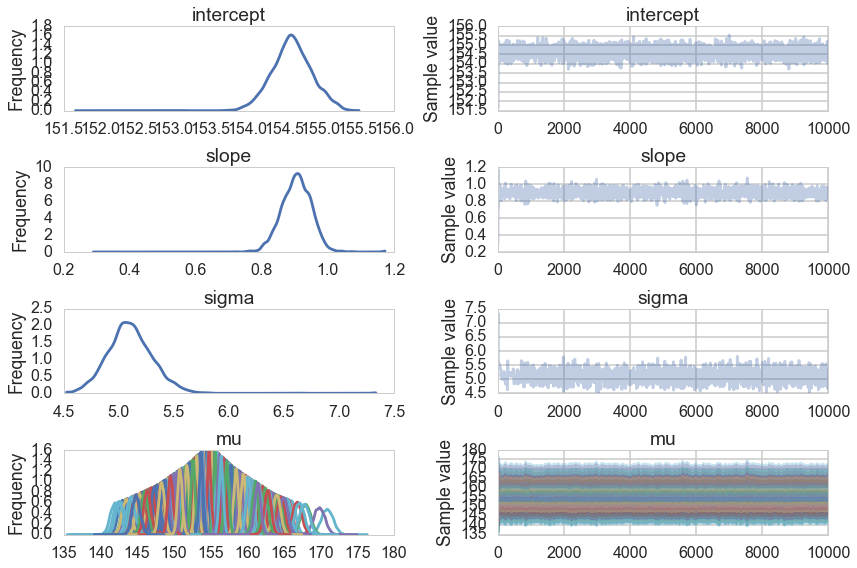

In [28]:
pm.traceplot(tracehm2c);

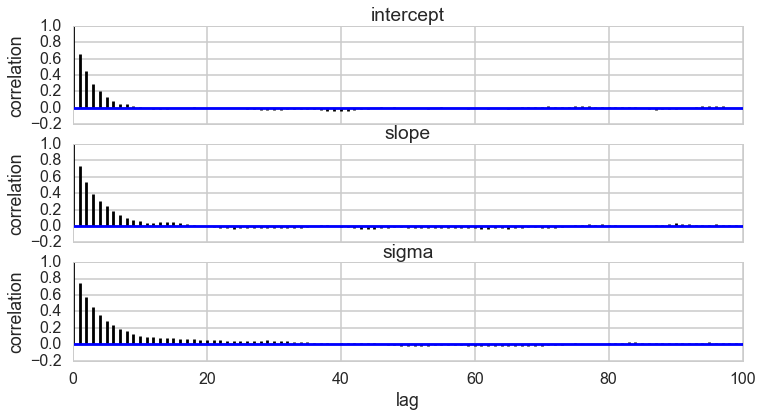

In [29]:
pm.autocorrplot(tracehm2c, varnames=['intercept', 'slope', 'sigma']);

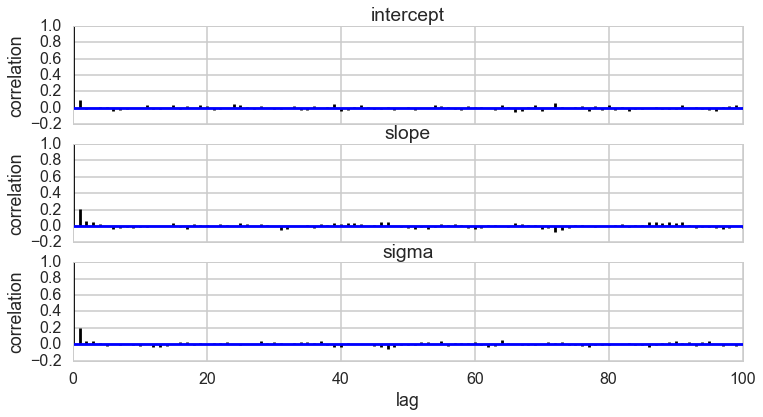

In [30]:
tr2c = tracehm2c[1000::5]
pm.autocorrplot(tr2c, varnames=['intercept', 'slope', 'sigma']);

Everything is kosher now! What just happened?

The intercept  is now the expected value of the outcome when the predictor is at its mean. This means we have removed any dependence from the baseline value of the predictor.

## Posteriors and Predictives

We can noe plot the posterior means directly.  We take the traces on the $mu$s and find each ones mean, and plot them

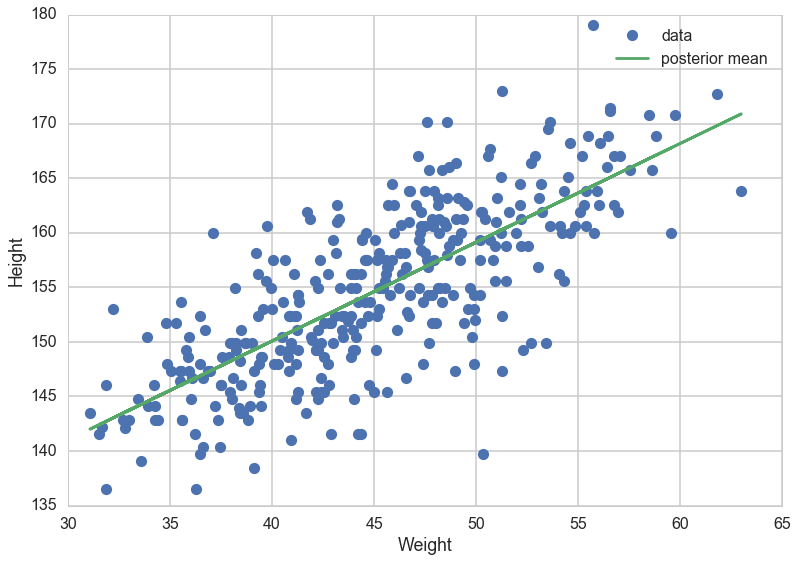

In [32]:
plt.plot(df2.weight, df2.height, 'o', label="data")
#plt.plot(df2.weight, tr2c['intercept'].mean() + tr2c['slope'].mean() * (df2.weight - df2.weight.mean()), label="posterior mean")
plt.plot(df2.weight, tr2c['mu'].mean(axis=0), label="posterior mean")
plt.xlabel("Weight")
plt.ylabel("Height")
plt.legend();

However, by including the $\mu$ as a deterministic in our traces we only get to see the traces at existing data points. If we want the traces on a grid of weights, we'll have to explivitly plug in the intercept and slope traces in the regression formula

In [33]:
meanweight = df2.weight.mean()
weightgrid = np.arange(25, 71)
mu_pred = np.zeros((len(weightgrid), len(tr2c)))
for i, w in enumerate(weightgrid):
    mu_pred[i] = tr2c['intercept'] + tr2c['slope'] * (w - meanweight)


We can see what the posterior density (on $\mu$) looks like at a given x (weight).

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


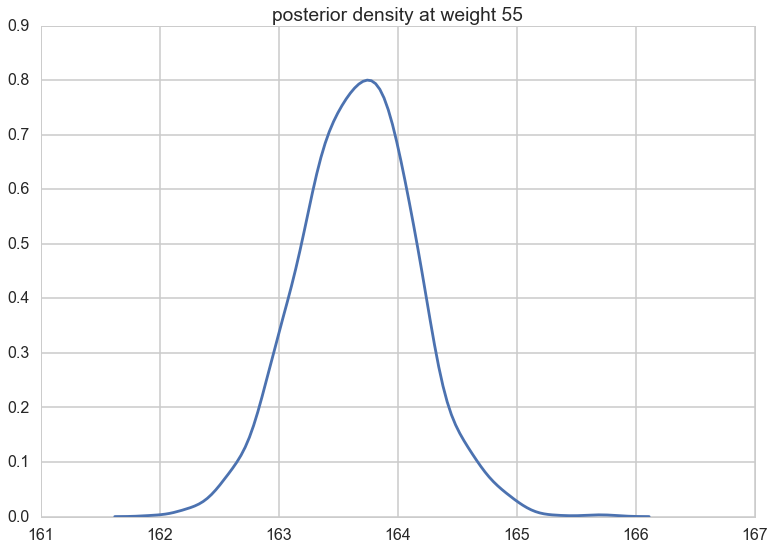

In [34]:
sns.kdeplot(mu_pred[30]);
plt.title("posterior density at weight {}".format(weightgrid[30]));

And we can create a plot of the posteriors using the HPD(Highest Posterior density interval) at each point on the grid.

In [35]:
mu_mean = mu_pred.mean(axis=1)
mu_hpd = pm.hpd(mu_pred.T)

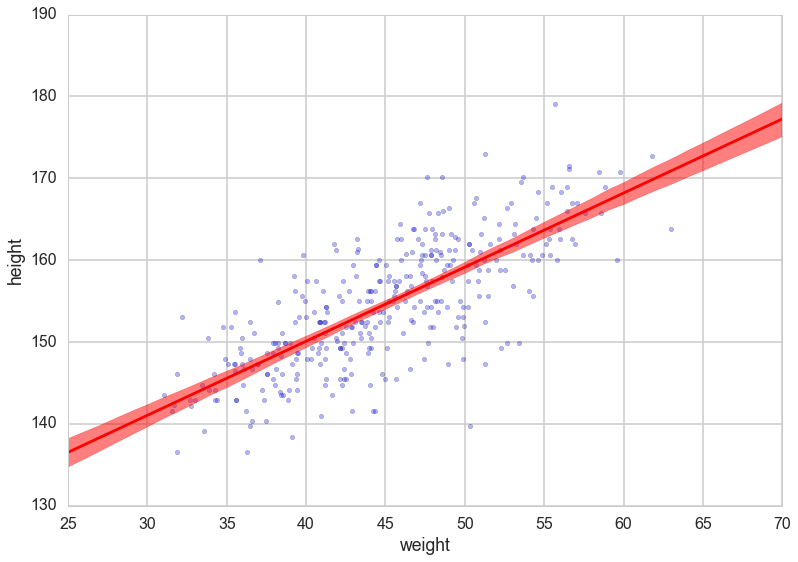

In [36]:
plt.scatter(df2.weight, df2.height, c='b', alpha=0.3)
plt.plot(weightgrid, mu_mean, 'r')
plt.fill_between(weightgrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim([weightgrid[0], weightgrid[-1]]);

Looks like our posterior $\mu$s are very tight. Why then is there such spread in the data?

In [37]:
hm2c.observed_RVs # these are the likelihoods

[height]

### The posterior predictive

Remember that the traces for each $\mu \vert x$ are traces of the "deterministic" parameter $\mu$ at a given x. These are not traces of $y \vert x$s, or heights, but rather, traces of the expected-height at a given x.

Remember that we need to smear the posterior out with the sampling distribution to get the posterior predictive.

`pymc3` makes this particularly simple for us, atleast at the points where we have data. We simply use the `pm.sample_ppc` function

In [38]:
postpred = pm.sample_ppc(tr2c, 1000, hm2c)

100%|██████████| 1000/1000 [00:19<00:00, 57.56it/s]    | 1/1000 [00:00<08:17,  2.01it/s]


Notice that these are at the 352 points where we have weights.

In [39]:
postpred['height'].shape

(1000, 352)

In [40]:
postpred_means = postpred['height'].mean(axis=0)

In [41]:
postpred_hpd = pm.hpd(postpred['height'])

Now when we plot the posterior predictives, we see that the error bars are much larger.

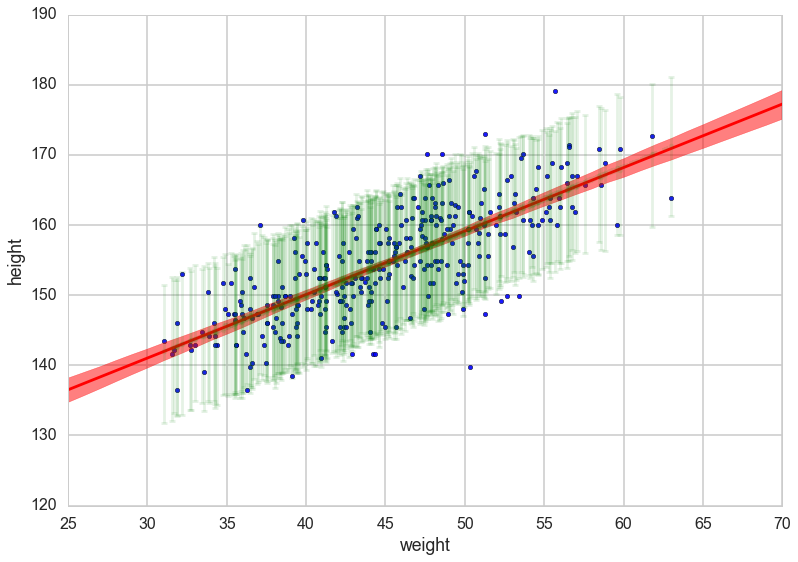

In [42]:
plt.scatter(df2.weight, df2.height, c='b', alpha=0.9)
plt.plot(weightgrid, mu_mean, 'r')
plt.fill_between(weightgrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
yerr=[postpred_means - postpred_hpd[:,0], postpred_hpd[:,1] - postpred_means] 
plt.errorbar(df2.weight, postpred_means, yerr=yerr, fmt='--.', c='g', alpha=0.1, capthick=3)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim([weightgrid[0], weightgrid[-1]]);

But we would like the posterior predictive at more than those 352 points...so here is the strategy we employ...

If we want 1000 samples (at each x) we, for each such sample, choose one of the posterior samples randomly, with replacement. We then get `gridsize` mus and one sigma from this posterior, which we then use to sample `gridsize` $y$'s from the likelihood.  This gives us 1000 $\times$ `gridsize` posterior predictives.

We will see later how to do this using theano shared variables.

In [44]:
len(tr2c)

1800

In [45]:
n_ppredsamps=1000
weightgrid = np.arange(25, 71)
meanweight = df2.weight.mean()
ppc_samples=np.zeros((len(weightgrid), n_ppredsamps))

for j in range(n_ppredsamps):
    k=np.random.randint(len(tr2c))#samples with replacement
    musamps = tr2c['intercept'][k] + tr2c['slope'][k] * (weightgrid - meanweight)
    sigmasamp = tr2c['sigma'][k]
    ppc_samples[:,j] = np.random.normal(musamps, sigmasamp)

In [46]:
ppc_samples_hpd = pm.hpd(ppc_samples.T)

And now we can plot using `fill_between`.

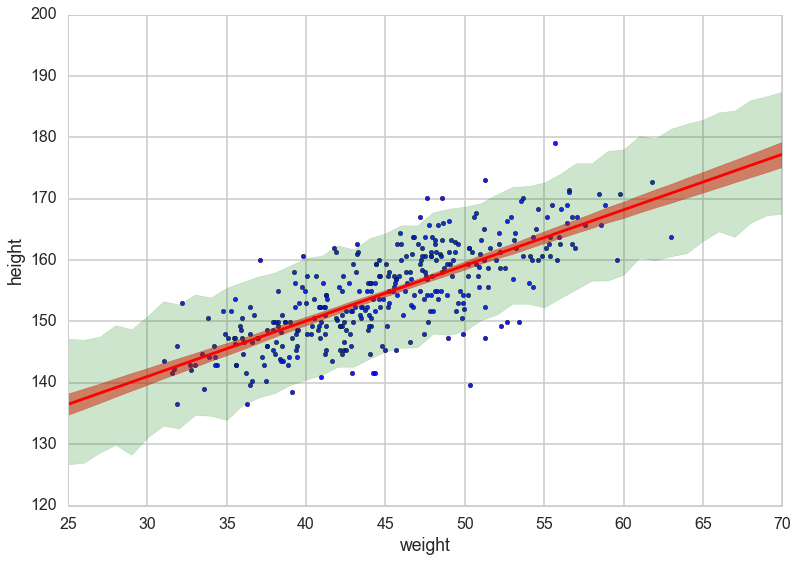

In [47]:
plt.scatter(df2.weight, df2.height, c='b', alpha=0.9)
plt.plot(weightgrid, mu_mean, 'r')
plt.fill_between(weightgrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(weightgrid, ppc_samples_hpd[:,0], ppc_samples_hpd[:,1], color='green', alpha=0.2)


plt.xlabel('weight')
plt.ylabel('height')
plt.xlim([weightgrid[0], weightgrid[-1]]);